## Исследование объявлений о продаже квартир",

В распоряжении данные архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо определять рыночную стоимость объектов недвижимости. Задача — установить параметры, которые влияют на стоимость квартир. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

## Шаг 1. Изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import bisect
import calendar

In [2]:
df_flats_info = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

display(df_flats_info.head())
df_flats_info.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

## Вывод

Рассмотрим полученную информацию подробнее.

Всего в таблице 22 столбца, тип данных столбцов различен.

Подробно разберём, какие в df_flats_info столбцы и какую информацию о заёмщике они содержат:
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Количество значений в столбцах различается. Это говорит о том, что в данных есть пропущенные значения.

## Шаг 2. Предобработка данных

### Обработка пропущенных значений

#### Обработка значений is_apartment

In [3]:
print('Количество значений в столбце апартаментов ')
print(df_flats_info['is_apartment'].value_counts())
df_flats_info['is_apartment'] = df_flats_info['is_apartment'].fillna(0)
print(df_flats_info.dtypes['is_apartment'], '- тип данных столбца до изменения')

df_flats_info['is_apartment'] = df_flats_info['is_apartment'].astype(bool)
print(df_flats_info.dtypes['is_apartment'], '- тип данных столбца после изменения')
print('Количество значений в столбце апартаментов ') 
print(df_flats_info['is_apartment'].value_counts())

Количество значений в столбце апартаментов 
False    2725
True       50
Name: is_apartment, dtype: int64
object - тип данных столбца до изменения
bool - тип данных столбца после изменения
Количество значений в столбце апартаментов 
False    23649
True        50
Name: is_apartment, dtype: int64


#### Результат обработки  значений is_apartment

Предположил, что источников с информацией о недвижимости было несколько и в некоторых из них не было указано это поле, поэтому и значение не задано,  в связи с чем заменил на False пропущенные значения.

#### Обработка значений locality_name

In [4]:
print(len(df_flats_info), '- количество строк до удаления')
df_flats_info.dropna(subset=['locality_name'], inplace = True)
print(len(df_flats_info), '- количество строк после удаления')

23699 - количество строк до удаления
23650 - количество строк после удаления


#### Результат обработки значений locality_name

49 значений населенных пунктов пропущено, в формате 23699 объектов - это немного (0.2%), вдобавок к этому заменить пропущенный населенный пункт весьма проблематично, в связи с чем строки с пропусками просто удалил. Считаю следующие возможные причины пропуска:
* Нахождение на границе нескольких населенных пунктов;
* Отсутствие этой графы в определенных источниках данных;
* Желание продавцов скрыть населенный пункт в корыстных целях.

#### Обработка значений last_price

In [5]:
df_flats_info['last_price'] = df_flats_info['last_price'] / 1000000

Исчисление в рублях неудобно, когда речь о стоимости квартир, в связи с чем привел к миллионам.

#### Обработка значений floors_total

In [6]:
communication_floors_price = df_flats_info.pivot_table(index='floors_total', values = 'last_price', aggfunc=['mean', 'count'])
communication_floors_price.columns = ['mean', 'count']
display(communication_floors_price.query('count > 472').sort_values('mean'))

floors_total_arr = [5, 9, 14, 12, 25, 16, 4, 6, 7]
boundaries_groups_last_price = [5.2, 5.6, 5.9, 6.3, 6.6, 7.1, 9.5, 12.5]

def coefficient_to_area(check_element):
    counter = bisect.bisect(boundaries_groups_last_price, check_element['last_price'])
    return floors_total_arr[counter]

df_flats_info['floors_total'] = df_flats_info.apply(coefficient_to_area, axis=1)

,mean,count
floors_total,,
5.0,5.193177,5775
9.0,5.244929,3758
14.0,5.852767,553
18.0,5.884754,505
3.0,5.914157,667
17.0,6.083673,833
12.0,6.174925,1361
25.0,6.658507,1075
16.0,6.766545,1375


#### Результат обработки значений floors_total

86 пропущенных значений в столбце floors_total могут быть заменены. Так как для каждой строки задана стоимость недвижимости и есть взаимосвязь между стоимостью и этажностью. Было решено заменить пропущенные значения на близкие варианты по цене. (472 - 2% от общего числа значений) Причины пропуска значений:
* Отсутствие этой графы в определенных источниках данных;
* Желание продавцов скрыть этажность в корыстных целях.

#### Обработка значений ceiling_height

In [7]:
df_flats_info['ceiling_height'].describe()

search_regularities = df_flats_info.dropna(subset=['ceiling_height'])
search_regularities = search_regularities.dropna(axis=1)

search_regularities = search_regularities[
    ['last_price', 'total_images', 'total_area', 'floors_total', 'floor', 'rooms', 'ceiling_height']]

df_flats_info['locality_name'] = df_flats_info['locality_name'].str.replace('посёлок', 'поселок')
list_locality = df_flats_info[['locality_name', 'ceiling_height']]

primary_replace = df_flats_info.groupby('locality_name')['ceiling_height'].median()

def primary_replace_ceiling_height(row):
    if math.isnan(row['ceiling_height']):
        return primary_replace[row['locality_name']]
    return row['ceiling_height']

print(df_flats_info['ceiling_height'].isnull().sum(),
      '- количество пропущенных высот потолков до первичной замены по населенному пункту')
df_flats_info['ceiling_height'] = df_flats_info.apply(primary_replace_ceiling_height, axis=1)
print(df_flats_info['ceiling_height'].isnull().sum(), 
      '- количество пропущенных высот потолков после первичной замены по населенному пункту')

median_height = df_flats_info['ceiling_height'].median()
df_flats_info['ceiling_height'] = df_flats_info['ceiling_height'].fillna(median_height)
print(df_flats_info['ceiling_height'].isnull().sum(),
      '- количество пропущенных высот потолков после вторичной замены оставшихся пропусков на медиану')

9160 - количество пропущенных высот потолков до первичной замены по населенному пункту
106 - количество пропущенных высот потолков после первичной замены по населенному пункту
0 - количество пропущенных высот потолков после вторичной замены оставшихся пропусков на медиану


#### Результат обработки значений ceiling_height

Проанализировав влияние различных характеристик на высоту потолков взаимосвязей с другими параметрами выявлено не было. В связи с большим числом пропущенных значений, заменил на медианное значение в соответствующем населенном пункте, после чего осталось меньше полупроцента пропущенных значений, их заменил на медианное. 

#### Обработка значений living_area и kitchen_area

###### Выявление закономерностей в данных без пропусков 

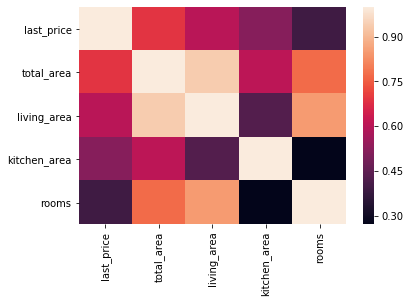

In [8]:
slice_data = df_flats_info[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']]
slice_data = slice_data.dropna(subset=['living_area', 'kitchen_area'])
sns.heatmap(slice_data.corr());

Взаимосвязь между общей площадью квартиры, жилой, а также площади кухни существует, а остальные параметры влияют минимально, в связи с чем в дальнейшем будем рассматривать эти три параметра.

In [9]:
slice_data['living_area'].value_counts()
slice_data['group_total_area'] = pd.qcut(slice_data['total_area'], 10)
slice_data['group2_total_area'] = pd.cut(slice_data['total_area'], [0,100,200,300,700])

slice_10_popular_area = slice_data.pivot_table(index ='group_total_area', 
                                               values = ['total_area', 'living_area', 'kitchen_area'], aggfunc='median')
slice_10_popular_area['percent_living_area'] = slice_10_popular_area['living_area'] / slice_10_popular_area['total_area']
slice_10_popular_area['percent_kitchen_area'] = slice_10_popular_area['kitchen_area'] / slice_10_popular_area['total_area']
slice_10_popular_area['count'] = slice_data['group_total_area'].value_counts()

slice_big_flat = slice_data.pivot_table(index ='group2_total_area',
                                        values = ['total_area', 'living_area', 'kitchen_area'], aggfunc='median')
slice_big_flat['percent_living_area'] = slice_big_flat['living_area'] / slice_big_flat['total_area']
slice_big_flat['percent_kitchen_area'] = slice_big_flat['kitchen_area'] / slice_big_flat['total_area']
slice_big_flat['count'] = slice_data['group2_total_area'].value_counts()

display(slice_10_popular_area)
display(slice_big_flat)      

,kitchen_area,living_area,total_area,percent_living_area,percent_kitchen_area,count
group_total_area,,,,,,
"(13.999, 33.5]",6.3,17.000,31.20,0.544872,0.201923,2126
"(33.5, 38.0]",9.0,17.200,36.00,0.477778,0.250000,2115
"(38.0, 42.5]",10.0,19.000,40.60,0.467980,0.246305,2047
"(42.5, 46.0]",7.0,27.400,44.60,0.614350,0.156951,2146
"(46.0, 52.2]",8.0,29.250,49.40,0.592105,0.161943,2046
"(52.2, 58.2]",8.5,32.055,55.40,0.578610,0.153430,2092
"(58.2, 65.0]",9.5,37.400,61.46,0.608526,0.154572,2167
"(65.0, 75.0]",10.0,42.400,70.00,0.605714,0.142857,2103
"(75.0, 93.3]",12.0,48.800,82.00,0.595122,0.146341,2009


,kitchen_area,living_area,total_area,percent_living_area,percent_kitchen_area,count
group2_total_area,,,,,,
"(0, 100]",9.0,29.51,50.0,0.590200,0.180000,19334
"(100, 200]",16.0,72.10,121.0,0.595868,0.132231,1420
"(200, 300]",25.3,148.00,235.0,0.629787,0.107660,145
"(300, 700]",37.0,220.00,373.1,0.589654,0.099169,43


Квартир площадью более 200 квадратных метров немного, однако разница в площадях присутствует, в связи с чем и выделил в отдельный класс.

###### Просмотр суммарных площадей в квартирах без указанной площади кухни и (или) жилой площади

In [45]:
pass_value = df_flats_info[df_flats_info['living_area'].isnull() | df_flats_info['kitchen_area'].isnull()]

pass_value['group_total_area'] = pd.cut(pass_value['total_area'], [0, 100, 200, 300, 700, 900])
display(pass_value['group_total_area'].value_counts())

(700, 900]    0
(300, 700]    0
(200, 300]    0
(100, 200]    0
(0, 100]      0
Name: group_total_area, dtype: int64

Просмотрев общую площадь квартир, в которых не указана отдельно площадь жилая или же кухни выявили небольшое количество квартир (<1% от всех пропущенных) с площадью > 400 квадратных метров в связи с чем объединил их в один класс.

###### Замена пропущенных значений в столбцах  living_area и kitchen_area

In [11]:
coefficients_array_kitchen_areas = [0, .2019, .25, .2463, .1569, .1619, .1534, .1546, .1429, .1463, .1322, .1076, .0992]
coefficients_array_living_areas = [0, .5449, .4778, .468, .6143, .5921, .5786, .6085, .6057, .5951, .5959, .6298, .5896]
boundaries_groups_total_areas = [13.9, 33.5, 38, 42.5, 46, 52.2, 58.2, 65, 75, 93.3, 200, 300]

def coefficient_to_area(check_element, result_coefficient_arr, boundaries=boundaries_groups_total_areas):
    counter = bisect.bisect(boundaries, check_element)
    return result_coefficient_arr[counter]

def insert_missing_kitchen_area(row):
    if math.isnan(row['kitchen_area']):
        row['kitchen_area'] = coefficient_to_area(row['total_area'], coefficients_array_kitchen_areas) * row['total_area']
        
    return row['kitchen_area']

def insert_missing_living_area(row):
    if math.isnan(row['living_area']):
        row['living_area'] = coefficient_to_area(row['total_area'], coefficients_array_living_areas) * row['total_area']
        
    return row['living_area']

print(df_flats_info['kitchen_area'].isnull().sum(), '- количество пропущенных площадей кухни, ', 
      df_flats_info['living_area'].isnull().sum(), '- количество пропущенных жилых площадей до замены')

df_flats_info['kitchen_area'] = df_flats_info.apply(insert_missing_kitchen_area, axis=1)
df_flats_info['living_area'] = df_flats_info.apply(insert_missing_living_area, axis=1)

print(df_flats_info['kitchen_area'].isnull().sum(), '- количество пропущенных площадей кухни, ',
      df_flats_info['living_area'].isnull().sum(), '- количество пропущенных жилых площадей после замены')

2269 - количество пропущенных площадей кухни,  1898 - количество пропущенных жилых площадей до замены
0 - количество пропущенных площадей кухни,  0 - количество пропущенных жилых площадей после замены


#### Результат обработки значений living_area и kitchen_area

Заменил пропущенные значения площадей максимально близкими по имеющимся данным, умножив соответствующий коэффициент площади кухни и жилой площади на общую площадь квартиры, которая была указана для всех квартир.

#### Обработка значений balcony

In [12]:
df_flats_info['balcony'] = df_flats_info['balcony'].fillna(0)

Предположим, что если балкон не указан, то его просто нет.

#### Обработка пропущенных значений days_exposition

In [13]:
print(df_flats_info['days_exposition'].median())
df_flats_info['days_exposition'] = df_flats_info['days_exposition'].fillna(90)

95.0


Чтобы не сильно сбивать медианное значение, но при этом поменять на уникальное значение в тех строках, где не было указано количество дней от публикации до снятия заменил на почти медианное (ближайшее, которое не встречалось в наборе данных) 

#### Обработка значений parks_nearest и airports_nearest

Заменим значения ближайших парков и водоемов на медианные, в случае, если есть информация о количестве ближайших в радиусе 3 километров.

In [14]:
median_distance_nearest_park = df_flats_info['parks_nearest'].median()
median_distance_nearest_pond = df_flats_info['ponds_nearest'].median()

df_flats_info.loc[df_flats_info.query('parks_nearest.isnull() & parks_around3000.notna()')['parks_nearest']
                  .index, 'parks_nearest'] = median_distance_nearest_park

df_flats_info.loc[df_flats_info.query('ponds_nearest.isnull() & ponds_around3000.notna()')['ponds_nearest']
                  .index, 'ponds_nearest'] = median_distance_nearest_pond

Оставшиеся пропуски располагаются в одних и тех же строках, в связи с чем заменяем на аномальные значения, близкие к медианным, чтобы не потерять, не испортить, но в связи с тем, что таких значений почти 20% рассмотрим их отдельно позднее. 

In [15]:
df_flats_info['ponds_around3000'] = df_flats_info['ponds_around3000'].fillna(0.5)
df_flats_info['parks_around3000'] = df_flats_info['parks_around3000'].fillna(0.5)

df_flats_info['airports_nearest'] = df_flats_info['airports_nearest'].fillna(26756.5)
df_flats_info['cityCenters_nearest'] = df_flats_info['cityCenters_nearest'].fillna(13105.1)
df_flats_info['parks_nearest'] = df_flats_info['parks_nearest'].fillna(454.6)
df_flats_info['ponds_nearest'] = df_flats_info['ponds_nearest'].fillna(502.1)

### Изменение типов данных

In [16]:
df_flats_info['first_day_exposition'] = pd.to_datetime(df_flats_info['first_day_exposition'])
df_flats_info['days_exposition'] = df_flats_info['days_exposition'].astype(int)
df_flats_info['balcony'] = df_flats_info['balcony'].astype(int)

display(df_flats_info.head())
df_flats_info.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13.000,108.0,2019-03-07,3,2.70,7,51.0000,8,False,...,25.0000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,90
1,7,3.350,40.4,2018-12-04,1,2.63,5,18.6000,1,False,...,11.0000,2,поселок Шушары,12817.0,18603.0,0.0,454.5,0.0,502.0,81
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.3000,4,False,...,8.3000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64.900,159.0,2015-07-24,3,2.70,7,94.7481,9,False,...,21.0198,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10.000,100.0,2018-06-19,2,3.03,6,32.0000,13,False,...,41.0000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        23650 non-null float64
cityCenters_nearest     23650 non-null float64
parks_around3000        23650 non-null float64
parks_nearest           23650 non-null float64
ponds_aroun

In [17]:
df_flats_info.duplicated().sum()

0

Дата была не в удобном формате. Количество балконов, дней, которые были размещены объявления привел к целому числу значений.
Количество прудов и парков в радиусе трех километров также можно было привести, но в связи с присвоением выделяющихся значений (0.5) это сделано не было. Дубликатов обнаружено не было.

## Вывод шага 2

В большом количестве столбцов были обнаружены пропуски, они были различны и заменялись из разных соображений. Причинами их появления считаю:
* Большое количество источников с различными признаками недвижимости;
* Корыстные соображения продавцов квартир;
* Незнание каких-то характеристик недвижимости;
* Мнение, что пропуск значения эквивалентно заполнением его нулем.

## Шаг 3. Посчитайте и добавьте в таблицу

### Добавление цены квадратного метра

In [18]:
df_flats_info['price_per_square_meter'] = round(1000 * df_flats_info['last_price'] / df_flats_info['total_area'])

### Добавление дня недели, месяца, года публикации

In [19]:
df_flats_info['day_of_week_publication'] = df_flats_info['first_day_exposition'].apply(lambda date: calendar.day_name[date.weekday()])

df_flats_info['month_publication'] = df_flats_info['first_day_exposition'].apply(lambda date: date.strftime('%B'))
df_flats_info['year_publication'] = df_flats_info['first_day_exposition'].apply(lambda date: date.year)


### Добавление варианта этажа

In [20]:
def input_status_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

df_flats_info['status_floor'] = df_flats_info.apply(input_status_floor, axis=1)

### Добавление соотношений площадей

In [21]:
df_flats_info['ratio_living_total'] = df_flats_info['living_area'] / df_flats_info['total_area']
df_flats_info['ratio_kitchen_total'] = df_flats_info['kitchen_area'] / df_flats_info['total_area']

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### Изучение площадей квартир

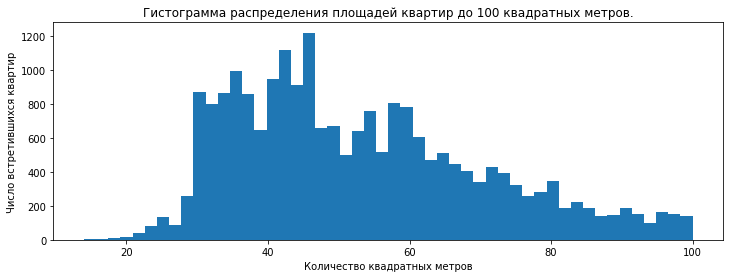

In [22]:
df_flats_info['total_area'].plot(kind='hist', bins=50, range=(13.99,100), figsize=(12, 4))
plt.title("Гистограмма распределения площадей квартир до 100 квадратных метров.")
plt.xlabel("Количество квадратных метров")
plt.ylabel("Число встретившихся квартир");

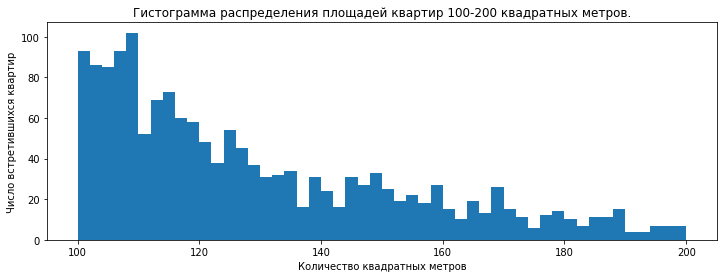

In [23]:
df_flats_info['total_area'].plot(kind='hist', bins=50, range=(100.001, 200), figsize=(12, 4))
plt.title("Гистограмма распределения площадей квартир 100-200 квадратных метров.")
plt.xlabel("Количество квадратных метров")
plt.ylabel("Число встретившихся квартир");

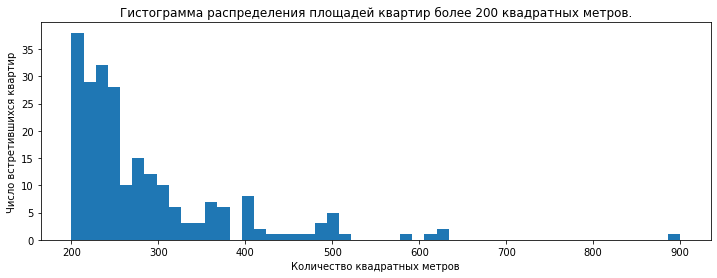

In [24]:
df_flats_info['total_area'].plot(kind='hist', bins=50, range=(200.001, 900), figsize=(12, 4))
plt.title("Гистограмма распределения площадей квартир более 200 квадратных метров.")
plt.xlabel("Количество квадратных метров")
plt.ylabel("Число встретившихся квартир");

### Изучение цен квартир

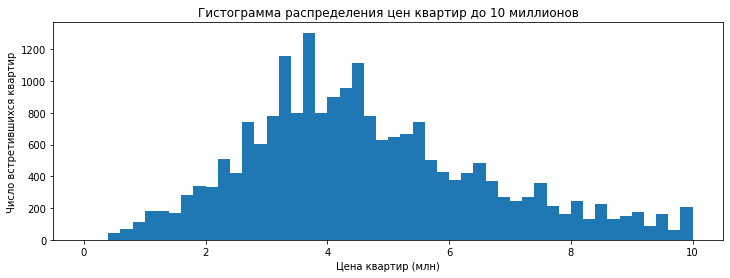

In [25]:
df_flats_info['last_price'].plot(kind='hist', bins=50, figsize=(12, 4), range=(0,10))
plt.title("Гистограмма распределения цен квартир до 10 миллионов")
plt.xlabel("Цена квартир (млн)")
plt.ylabel("Число встретившихся квартир");

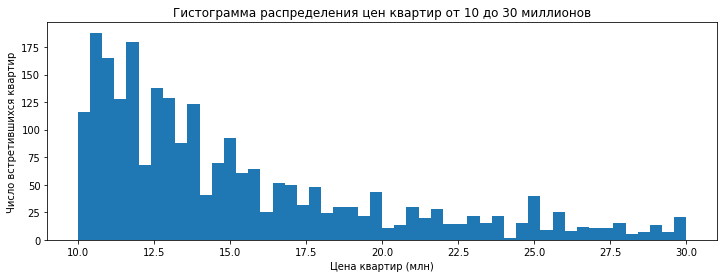

In [26]:
df_flats_info['last_price'].plot(kind='hist', bins=50, figsize=(12, 4), range=(10.001,30))
plt.title("Гистограмма распределения цен квартир от 10 до 30 миллионов")
plt.xlabel("Цена квартир (млн)")
plt.ylabel("Число встретившихся квартир");

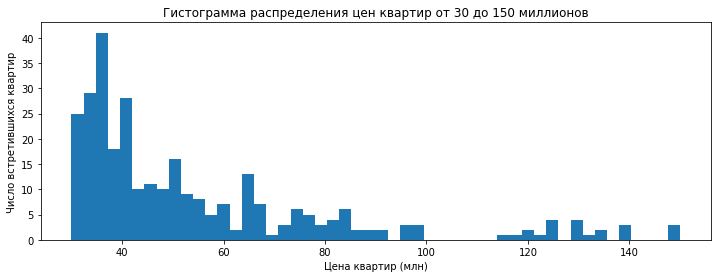

In [27]:
df_flats_info['last_price'].plot(kind='hist', bins=50, figsize=(12, 4), range=(30.001,150))
plt.title("Гистограмма распределения цен квартир от 30 до 150 миллионов")
plt.xlabel("Цена квартир (млн)")
plt.ylabel("Число встретившихся квартир");

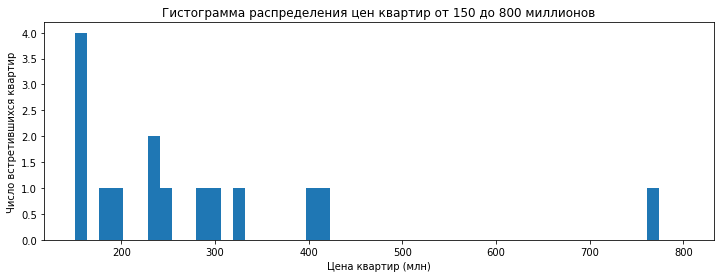

In [28]:
df_flats_info['last_price'].plot(kind='hist', bins=50, figsize=(12, 4), range=(150.001,800))
plt.title("Гистограмма распределения цен квартир от 150 до 800 миллионов")
plt.xlabel("Цена квартир (млн)")
plt.ylabel("Число встретившихся квартир");

### Изучение числа комнат

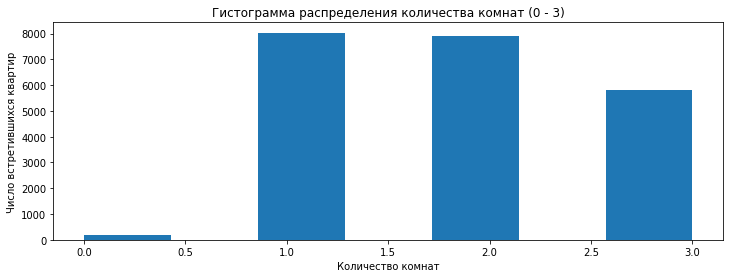

In [29]:
df_flats_info['rooms'].plot(kind='hist', bins=7, figsize=(12, 4), range=(0,3))
plt.title("Гистограмма распределения количества комнат (0 - 3)")
plt.xlabel("Количество комнат")
plt.ylabel("Число встретившихся квартир");

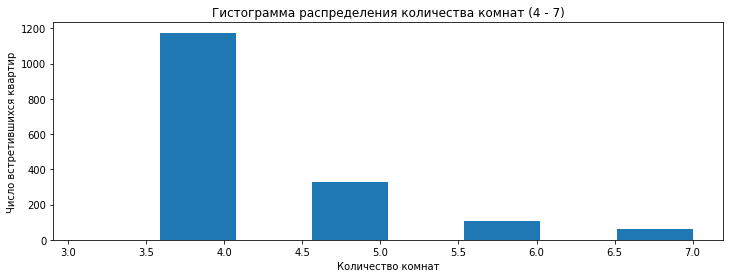

In [30]:
df_flats_info['rooms'].plot(kind='hist', bins=8, figsize=(12, 4), range=(3.1,7))
plt.title("Гистограмма распределения количества комнат (4 - 7)")
plt.xlabel("Количество комнат")
plt.ylabel("Число встретившихся квартир");

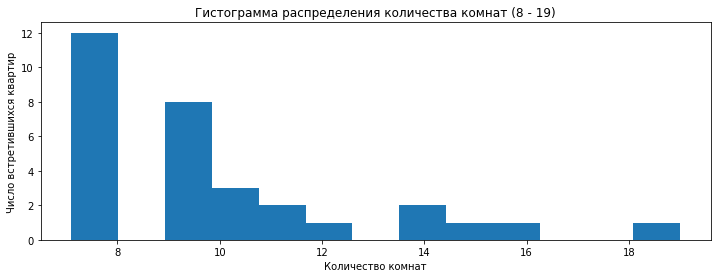

In [31]:
df_flats_info['rooms'].plot(kind='hist', bins=13, figsize=(12, 4), range=(7.1, 19))
plt.title("Гистограмма распределения количества комнат (8 - 19)")
plt.xlabel("Количество комнат")
plt.ylabel("Число встретившихся квартир");

### Изучение высот потолков

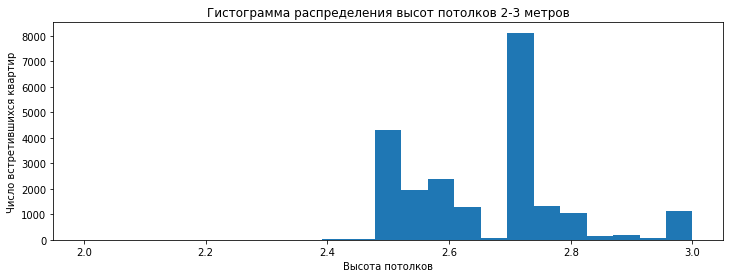

In [32]:
df_flats_info['ceiling_height'].plot(kind='hist', bins=23, figsize=(12, 4), range=(2,3))
plt.title("Гистограмма распределения высот потолков 2-3 метров")
plt.xlabel("Высота потолков")
plt.ylabel("Число встретившихся квартир");

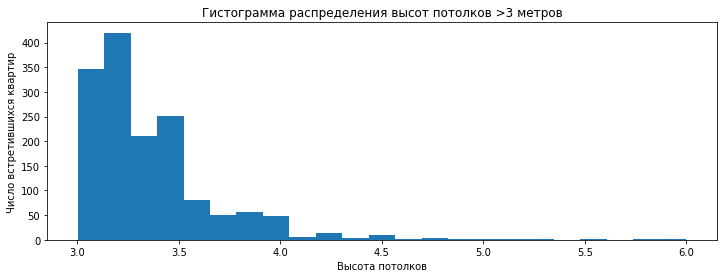

In [33]:
df_flats_info['ceiling_height'].plot(kind='hist', bins=23, figsize=(12, 4), range=(3.001,6))
plt.title("Гистограмма распределения высот потолков >3 метров")
plt.xlabel("Высота потолков")
plt.ylabel("Число встретившихся квартир");

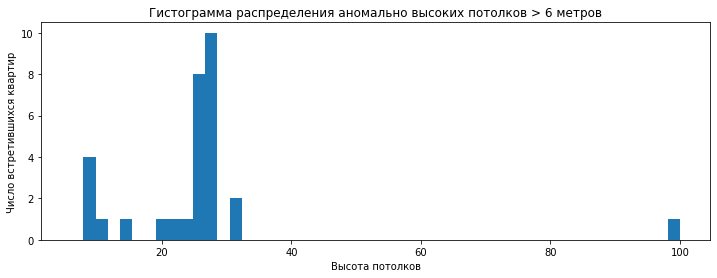

In [34]:
df_flats_info['ceiling_height'].plot(kind='hist', bins=50, figsize=(12, 4), range=(6.001,100))
plt.title("Гистограмма распределения аномально высоких потолков > 6 метров")
plt.xlabel("Высота потолков")
plt.ylabel("Число встретившихся квартир");

### Изучение времени продаж

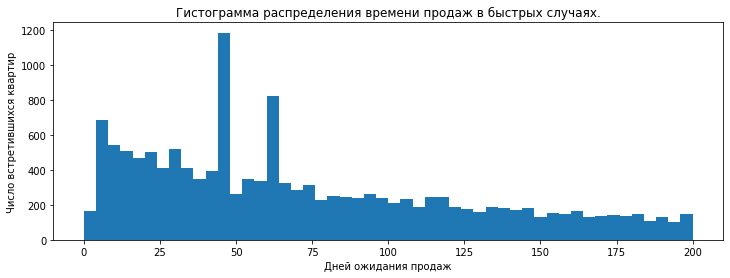

In [35]:
df_without_replacement = df_flats_info.query('days_exposition != 90')
df_without_replacement['days_exposition'].plot(kind='hist', bins=50, figsize=(12, 4), range=(0,200))
plt.title("Гистограмма распределения времени продаж в быстрых случаях.")
plt.xlabel("Дней ожидания продаж")
plt.ylabel("Число встретившихся квартир");

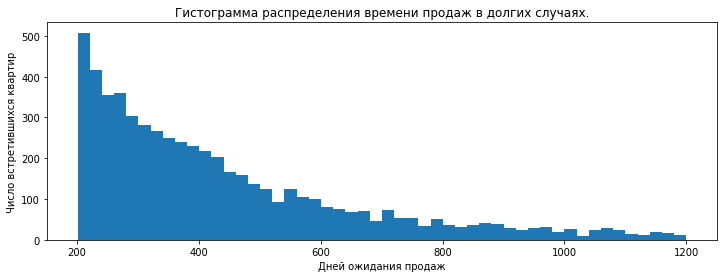

In [36]:
df_without_replacement['days_exposition'].plot(kind='hist', bins=50, figsize=(12, 4), range=(201, 1200))
plt.title("Гистограмма распределения времени продаж в долгих случаях.")
plt.xlabel("Дней ожидания продаж")
plt.ylabel("Число встретившихся квартир");

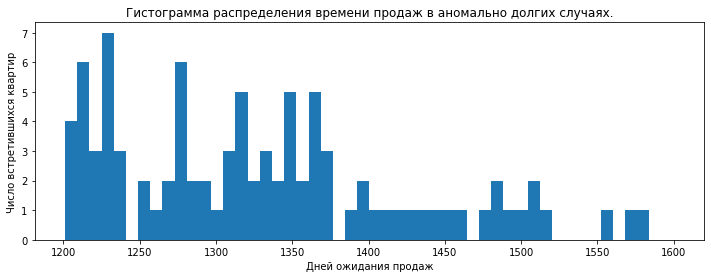

In [37]:
df_without_replacement['days_exposition'].plot(kind='hist', bins=50, figsize=(12, 4), range=(1201, 1600))
plt.title("Гистограмма распределения времени продаж в аномально долгих случаях.")
plt.xlabel("Дней ожидания продаж")
plt.ylabel("Число встретившихся квартир");

In [38]:
df_without_replacement.groupby(pd.qcut(df_without_replacement['days_exposition'],10)).mean().round(decimals=2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,year_publication,ratio_living_total,ratio_kitchen_total
days_exposition,,,,,,,,,,,,,,,,,,,,,
"(0.999, 17.0]",9.54,5.49,53.50,1.85,2.71,6.80,30.45,6.12,0.0,0.01,...,13940.06,0.55,463.12,0.63,519.37,9.43,99.81,2017.82,0.56,0.19
"(17.0, 34.0]",9.70,5.97,54.28,1.89,2.77,6.70,30.87,6.31,0.0,0.02,...,14423.97,0.54,462.37,0.69,511.55,25.73,100.25,2017.74,0.56,0.19
"(34.0, 47.0]",8.53,4.37,49.76,1.77,2.68,5.94,28.30,5.90,0.0,0.01,...,14938.28,0.53,460.38,0.61,517.08,42.53,85.82,2017.57,0.56,0.20
"(47.0, 66.0]",9.64,5.68,56.66,1.99,2.70,7.32,32.34,6.48,0.0,0.01,...,14267.46,0.54,465.46,0.69,517.22,57.92,98.17,2017.56,0.56,0.19
"(66.0, 97.0]",10.08,5.58,55.88,1.97,2.71,6.81,31.95,6.21,0.0,0.00,...,13964.00,0.55,465.24,0.68,507.31,81.26,96.09,2017.44,0.56,0.19
"(97.0, 137.0]",10.02,6.22,59.21,2.05,2.70,6.84,33.79,5.96,0.0,0.00,...,14254.07,0.56,467.16,0.68,514.32,116.37,96.26,2017.34,0.56,0.19
"(137.0, 192.0]",10.13,6.18,59.54,2.06,2.71,6.73,33.98,5.82,0.0,0.01,...,14021.73,0.58,467.87,0.68,511.37,163.25,97.31,2017.20,0.56,0.19
"(192.0, 290.0]",9.80,6.91,61.71,2.11,2.75,6.75,35.14,5.75,0.0,0.00,...,14153.36,0.61,472.18,0.75,503.87,236.69,98.83,2017.02,0.56,0.18
"(290.0, 462.0]",9.78,7.20,64.54,2.18,2.74,6.91,37.30,5.72,0.0,0.00,...,13820.17,0.60,467.82,0.73,502.59,368.75,98.79,2016.69,0.57,0.18


### Мнение о времени продаж

В пятидесяти процентах случаях жилплощадь продается за 3 месяца, если недвижимость продается дольше 462 дней, считаю это аномально долгим, в случае продажи за 17 дней и менее - аномально быстрой 

### Обработка редких и выбивающихся значений

45      879
60      538
7       234
30      208
4       174
       ... 
807       1
871       1
951       1
999       1
1175      1
Name: days_exposition, Length: 1140, dtype: int64

45      879
60      538
30      208
4       174
3       158
       ... 
871       1
951       1
999       1
1111      1
1255      1
Name: days_exposition, Length: 976, dtype: int64

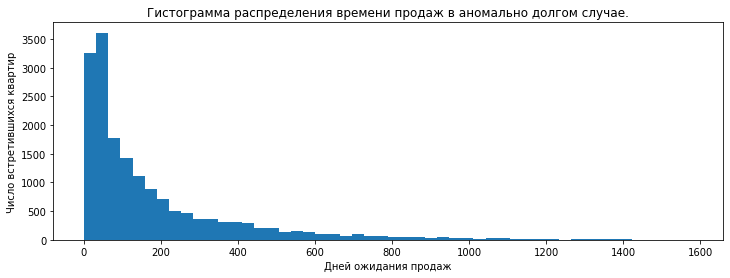

In [39]:
display(df_without_replacement['days_exposition'].value_counts())
df_without_abnormal = df_without_replacement.query('days_exposition % 15 != 0')
df_without_abnormal = df_without_replacement.query('days_exposition % 7 != 0')
display(df_without_abnormal['days_exposition'].value_counts())

df_without_abnormal['days_exposition'].plot(kind='hist', bins=50, figsize=(12, 4))
plt.title("Гистограмма распределения времени продаж в аномально долгом случае.")
plt.xlabel("Дней ожидания продаж")
plt.ylabel("Число встретившихся квартир");

In [40]:
df_without_abnormal.query('days_exposition > 1200')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,day_of_week_publication,month_publication,year_publication,status_floor,ratio_living_total,ratio_kitchen_total
353,4,5.9900,43.5,2015-05-08,1,3.00,12,25.00000,4,False,...,0.0,502.0,1292,138.0,Friday,May,2015,другой,0.574713,0.216092
398,7,12.7890,79.3,2014-12-09,2,3.00,7,43.10000,5,False,...,0.0,502.0,1345,161.0,Tuesday,December,2014,другой,0.543506,0.221942
437,12,3.3500,37.0,2015-02-24,1,2.55,5,17.80000,6,False,...,1.0,755.0,1273,91.0,Tuesday,February,2015,другой,0.481081,0.227027
521,20,25.7173,230.1,2015-01-21,3,2.60,7,130.00000,1,False,...,3.0,278.0,1441,112.0,Wednesday,January,2015,первый,0.564972,0.113429
749,6,4.1500,30.8,2015-03-19,1,2.60,5,15.40000,3,False,...,1.0,232.0,1336,135.0,Thursday,March,2015,другой,0.500000,0.282468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22126,10,5.2300,61.8,2015-04-28,3,2.60,9,39.40000,2,False,...,0.0,502.0,1240,85.0,Tuesday,April,2015,другой,0.637540,0.152104
22455,1,11.6156,81.8,2015-08-10,3,3.10,6,43.83000,3,False,...,2.0,427.0,1334,142.0,Monday,August,2015,другой,0.535819,0.178240
23034,0,4.1000,88.0,2014-12-10,4,2.55,5,60.70000,4,False,...,0.5,502.1,1202,47.0,Wednesday,December,2014,другой,0.689773,0.093182
23052,5,11.4460,90.9,2015-05-25,3,2.70,6,56.90000,3,False,...,1.0,503.0,1201,126.0,Monday,May,2015,другой,0.625963,0.117712


### Вывод о редких и выбивающихся значений

Аномальным кажется, что наиболее частыми значениями являются числа кратные полумесяцам, неделям. После удаление таких значений распределение дней стало похожим на ожидаемое - Пуассоновское. Хвост длинный, но каких-то закономерностей с другими параметрами найдено не было, в связи с чем оставил его, предположив, что некоторые квартиры могут хуже продаваться.

### Выявление факторов влияющих на стоимость недвижимости

In [48]:
min_research_df = df_flats_info[['rooms', 'cityCenters_nearest', 'total_area', 'last_price', 'status_floor',
                                 'day_of_week_publication', 'month_publication', 'year_publication']]

min_research_df.loc[:,'month_publication_id'] = min_research_df['month_publication'].astype('category')
cat_columns = min_research_df.select_dtypes(['category']).columns
min_research_df.loc[:,'month_publication_id'] = min_research_df[cat_columns].apply(lambda x: x.cat.codes)

min_research_df.loc[:,'status_floor_id'] = min_research_df['status_floor'].astype('category')
cat_columns2 = min_research_df.select_dtypes(['category']).columns
min_research_df.loc[:,'status_floor_id'] = min_research_df[cat_columns2].apply(lambda x: x.cat.codes)

min_research_df.loc[:,'day_of_week_publication'] = min_research_df['day_of_week_publication'].astype('category')
cat_columns3 = min_research_df.select_dtypes(['category']).columns
min_research_df.loc[:,'day_of_week_publication_id'] = min_research_df[cat_columns3].apply(lambda x: x.cat.codes)

min_research_df.corr()['last_price']

rooms                         0.363421
cityCenters_nearest          -0.191161
total_area                    0.653743
last_price                    1.000000
year_publication             -0.042927
month_publication_id         -0.005348
status_floor_id              -0.045637
day_of_week_publication_id         NaN
Name: last_price, dtype: float64

На стоимость квартир в порядке увеличения воздействия влияют следующие факторы:
* Близость к центру;
* Количество комнат;
* Общая площадь недвижимости.

### Анализ стоимости м<sup>2</sup> 10 наиболее частых населенных пунктов

58.10 - минимальная стоимость квадратного метра среди самых популярных населенных пунктов - Выборг
114.85 - максимальная стоимость квадратного метра среди самых популярных населенных пунктов - Санкт-Петербург


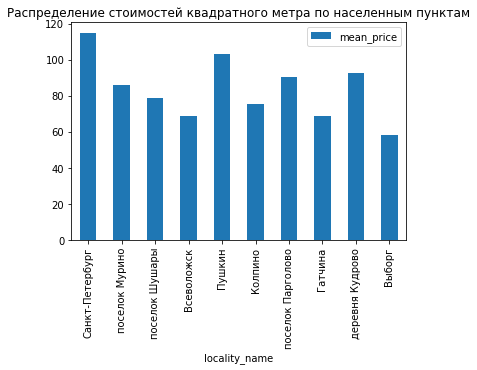

In [42]:
most_popular_location = pd.pivot_table(df_flats_info, index='locality_name', values = 'price_per_square_meter', 
                                           aggfunc = ['mean', 'count'])
most_popular_location.columns = ['mean_price', 'count']
most_popular_location.sort_values('count', ascending=False).head(10).plot.bar(y='mean_price',
             use_index=True, title='Распределение стоимостей квадратного метра по населенным пунктам');


min_price = most_popular_location.query('locality_name == "Выборг"')['mean_price']
max_price = most_popular_location.query('locality_name == "Санкт-Петербург"')['mean_price']
print('{:.2f} - минимальная стоимость квадратного метра среди самых популярных населенных пунктов {}'.format(float(min_price), '- Выборг'))
print('{:.2f} - максимальная стоимость квадратного метра среди самых популярных населенных пунктов {}'.format(float(max_price), '- Санкт-Петербург'))

### Выявление центра Санкт-Петербурга

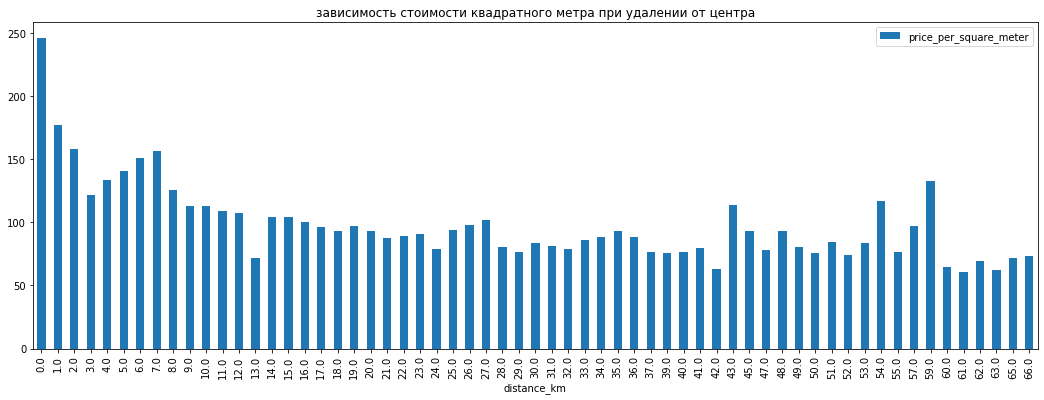

In [43]:
df_flats_info['distance_km'] = round(df_flats_info['cityCenters_nearest'] / 1000)
df_flats_info.groupby('distance_km').agg({'price_per_square_meter' : 'mean'}).plot(kind='bar', figsize=(18, 6),
        title='зависимость стоимости квадратного метра при удалении от центра');

### Закономерности в ценах при удалении от центра

Центром Питера считается район вблизь Петропавловской крепости, где ожидаемо высока цена за квадратный метр, но открыв тепловую карту цен на жилье была выделена еще одна горячая область - Крестовский остров, который как раз и дает возвышение с 4 по 7 км удаления от центра. В связи с чем центром считаю квартиры с удалением менее 3 км от центра.

### Анализ параметров квартир в центре

In [44]:
the_property_in_center = df_flats_info.query('distance_km <= 2')
print('Медианная высота потолков в центре - ', the_property_in_center['ceiling_height'].median(),
      'Медианная высота потолков по городу - ', df_flats_info['ceiling_height'].median())

print('Медианная общая площадь недвижимости в центре - ', the_property_in_center['total_area'].median(),
      'Медианная общая площадь недвижимости по городу - ', df_flats_info['total_area'].median())

print('Медианное количество комнат недвижимости в центре - ', the_property_in_center['rooms'].median(),
      'Медианное количество комнат недвижимости по городу - ', df_flats_info['rooms'].median())

print('Медианная стоимость недвижимости в центре - ', the_property_in_center['last_price'].median(),
      'Медианная стоимость недвижимости по городу - ', df_flats_info['last_price'].median())

slice_check_depends_center = the_property_in_center[['last_price', 'rooms', 'floor', 'days_exposition', 'cityCenters_nearest']]
slice_check_depends_all = df_flats_info[['last_price', 'rooms', 'floor', 'days_exposition', 'cityCenters_nearest']]

display(slice_check_depends_center.corr()['last_price'], 'корреляция параметров для квартир в центре')
display(slice_check_depends_all.corr()['last_price'], 'корреляция параметров для квартир по всему городу')

Медианная высота потолков в центре -  3.0 Медианная высота потолков по городу -  2.7
Медианная общая площадь недвижимости в центре -  90.0 Медианная общая площадь недвижимости по городу -  52.0
Медианное количество комнат недвижимости в центре -  3.0 Медианное количество комнат недвижимости по городу -  2.0
Медианная стоимость недвижимости в центре -  10.7 Медианная стоимость недвижимости по городу -  4.65


last_price             1.000000
rooms                  0.218768
floor                  0.291409
days_exposition        0.014791
cityCenters_nearest   -0.070663
Name: last_price, dtype: float64

'корреляция параметров для квартир в центре'

last_price             1.000000
rooms                  0.363421
floor                  0.026770
days_exposition        0.064662
cityCenters_nearest   -0.191161
Name: last_price, dtype: float64

'корреляция параметров для квартир по всему городу'

Квартиры вблизь центра оказались дороже в среднем в 2 раза, чем квартиры по Санкт-Петербургу, но при этом и площадь таких квартир выше в 1.73 раза больше, комнат больше в 1.5 раза. Потолки выше на 10%. Однако если рассматривать влияние парметров квартиры на стоимость, то существует некоторое отличие, так количество комнат оказывает меньшее воздействие на цену жилплощади, однако этаж, на котором расположена квартира становится важнее. Закономерность оказалось ожидаемой.

### Шаг 5. Общий вывод

В исходных данных оказалось множество пропусков в 13 из 22 столбцов были пропуски! Они были различны, полагаю, что причинами могли быть следующие:
* Пропуск с подразумеванием нуля;
* Незаполнение некоторых параметров в связи с возможным их отсутствием в каких-то источниках;
* Корыстные побуждения людей, подающих объявления;
* Незнание значений некоторых параметров;

Значение некоторых столбцов приведены к другим типам для удобства, так дата теперь выглядит более привычно, как и целое число балконов и дней, которые объявление было выставлено.

Были рассчитаны и добавлены следующие столбцы:
* Цена квадратного метра;
* День недели, месяц и год публикации объявления;
* Этаж квартиры: варианты — первый, последний, другой;
* Соотношение жилой и общей площади, а также отношение площади кухни к общей.

Изучены и построены гистограммы следующих параметров: площадь, цена, число комнат, высота потолков, время продажи квартиры. Выявлено, что 50% продаж осуществлялись за первые 3 месяца, однако отдельные экземпляры продавались и более трех лет, показалось странным, что частым временем продажи было время кратное половине месяца, неделе. Было выявлено, что на стоимость квартир в порядке увеличения воздействия влияют следующие факторы:
* Близость к центру;
* Количество комнат;
* Общая площадь недвижимости.

А день выставление объявление влияет незначительно на продажу. В зависимости от населенного пункта существенно отличалась стоимость квадратного метра, самым дорогим оказался квадратный метр непосредственно в Санкт-Петербурге (114.85 тысяч), а самым дешевым квадратный метр в Выборге (58.10 тысяч). Выявлено, что существует две области с более дорогими квартирами, непосредственно близь Петропавловской крепости и в районе Крестовского острова. При этом при рассмотрении квартир в радиусе 2 километрах центра оказалось, что потолки в среднем на 10% выше, квартиры на комнату больше, стоимость более чем в два раза выше, средняя площадь на 70% больше. При этом на стоимость недвижимости, в центре, влияние близости к центру меньше, чем в среднем по городу, а воздействие номера этажа на цену наоборот возрасла.

По итогам работы были выявлены факторы, влияющие на стоимость квартир, которые можно использовать для определения мошеннических предложений.